In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

### Load Data

In [2]:
df = pd.read_csv("15min_dateset.csv")
df.drop('Unnamed: 0', inplace = True, axis = 1)
df.head()

,Date,Type,from,EXP,jul_date,hour_angle,max_wind_speed,avg_wind_speed,R1,R2,...,HYBL_one,HYBL_two,HYBL_three,HYBL_four,HYBL_five,diff_temp,geo_cbl,veg_sfc,best_4_layer,ws_700
0,2017-01-07 06:00:00,ANDE,MESONET,1/7/17,7,-1.570795,2.332608,1.295893,2.630564,2.322274,...,0.629230,0.903721,3.610055,5.011670,6.054984,0.739,-5000.0,40.293,23.757,16.787335
1,2017-01-07 06:15:00,ANDE,MESONET,1/7/17,7,-1.505345,1.555072,0.647947,2.055383,1.813005,...,0.748575,1.493288,3.643217,5.232982,6.394255,1.050,-5000.0,40.293,23.959,16.195689
2,2017-01-07 06:30:00,ANDE,MESONET,1/7/17,7,-1.439895,2.332608,1.360688,1.792587,1.671478,...,1.154196,1.645343,3.346854,5.054551,6.395084,1.211,-5000.0,40.293,24.118,15.636587
3,2017-01-07 06:45:00,ANDE,MESONET,1/7/17,7,-1.374446,1.555072,0.453563,1.442889,1.352497,...,2.183654,2.266223,3.550607,5.363623,6.869857,0.943,-5000.0,40.293,24.220,16.767452
4,2017-01-07 07:00:00,ANDE,MESONET,1/7/17,7,-1.308996,2.526992,1.360688,2.283417,1.677404,...,2.407290,2.633109,3.692489,5.309871,6.783159,0.751,-5000.0,40.293,24.149,17.249375


### Correlation 

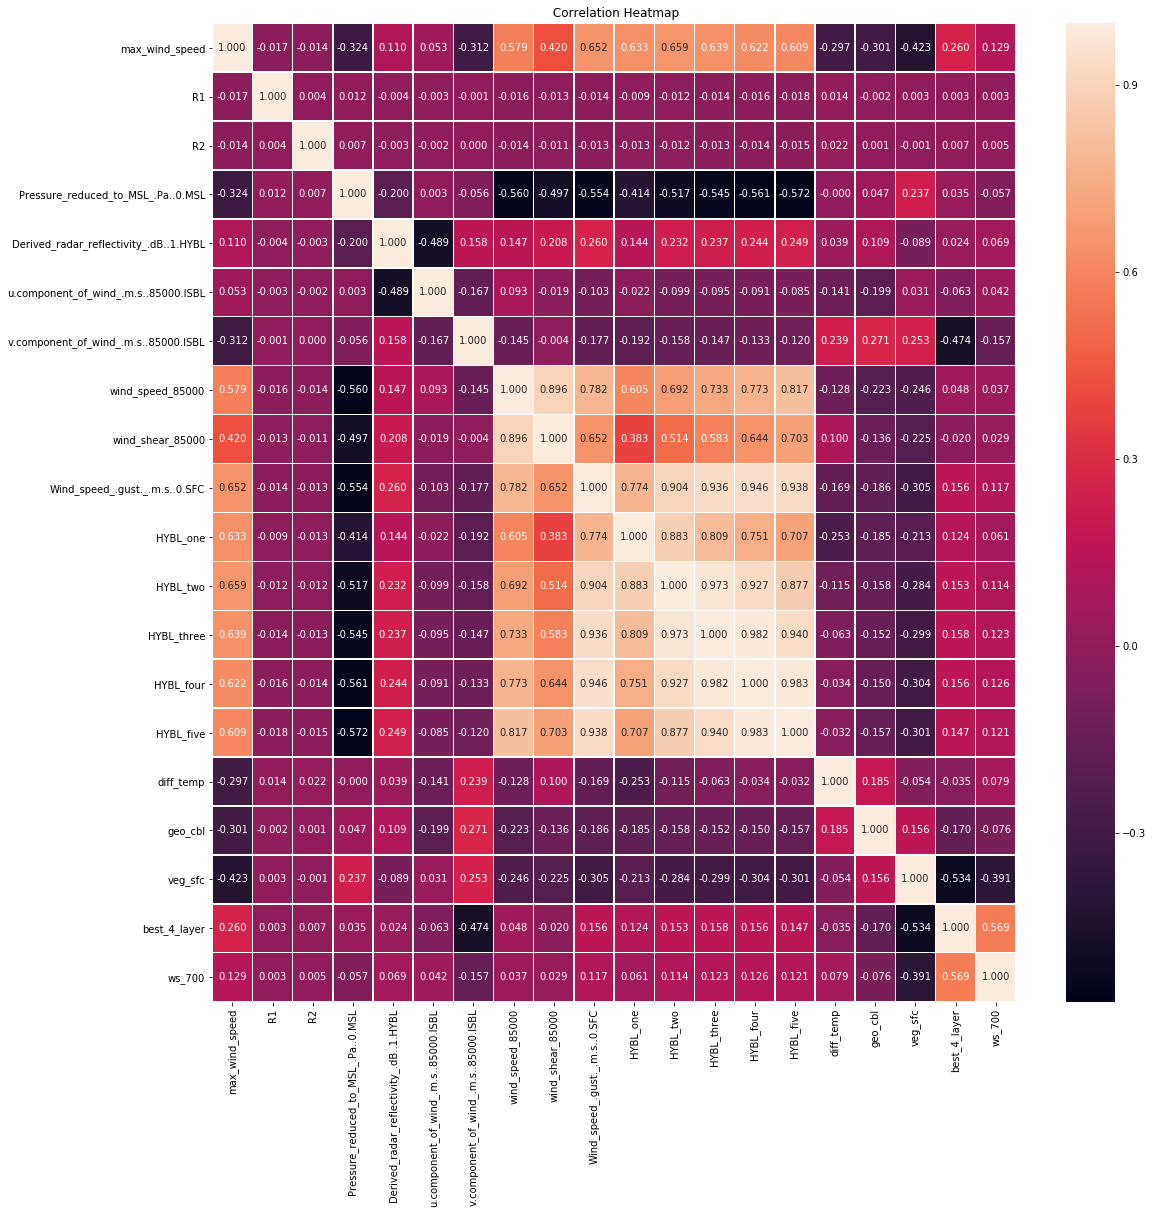

In [3]:
df4 = df[['max_wind_speed', 'R1', 'R2',
       'Pressure_reduced_to_MSL_.Pa..0.MSL',
       'Derived_radar_reflectivity_.dB..1.HYBL',
       'u.component_of_wind_.m.s..85000.ISBL',
       'v.component_of_wind_.m.s..85000.ISBL', 'wind_speed_85000',
       'wind_shear_85000', 'Wind_speed_.gust._.m.s..0.SFC', 'HYBL_one',
       'HYBL_two', 'HYBL_three', 'HYBL_four', 'HYBL_five', 'diff_temp',
       'geo_cbl', 'veg_sfc', 'best_4_layer', 'ws_700']]

cor = df4.corr()
f,ax = plt.subplots(figsize = (18,18))
plt.title(' Correlation Heatmap')
sns.heatmap(cor, annot = True, linewidths = .5, fmt='.3f', ax = ax)

### Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21dd8908>,
      dtype=object)

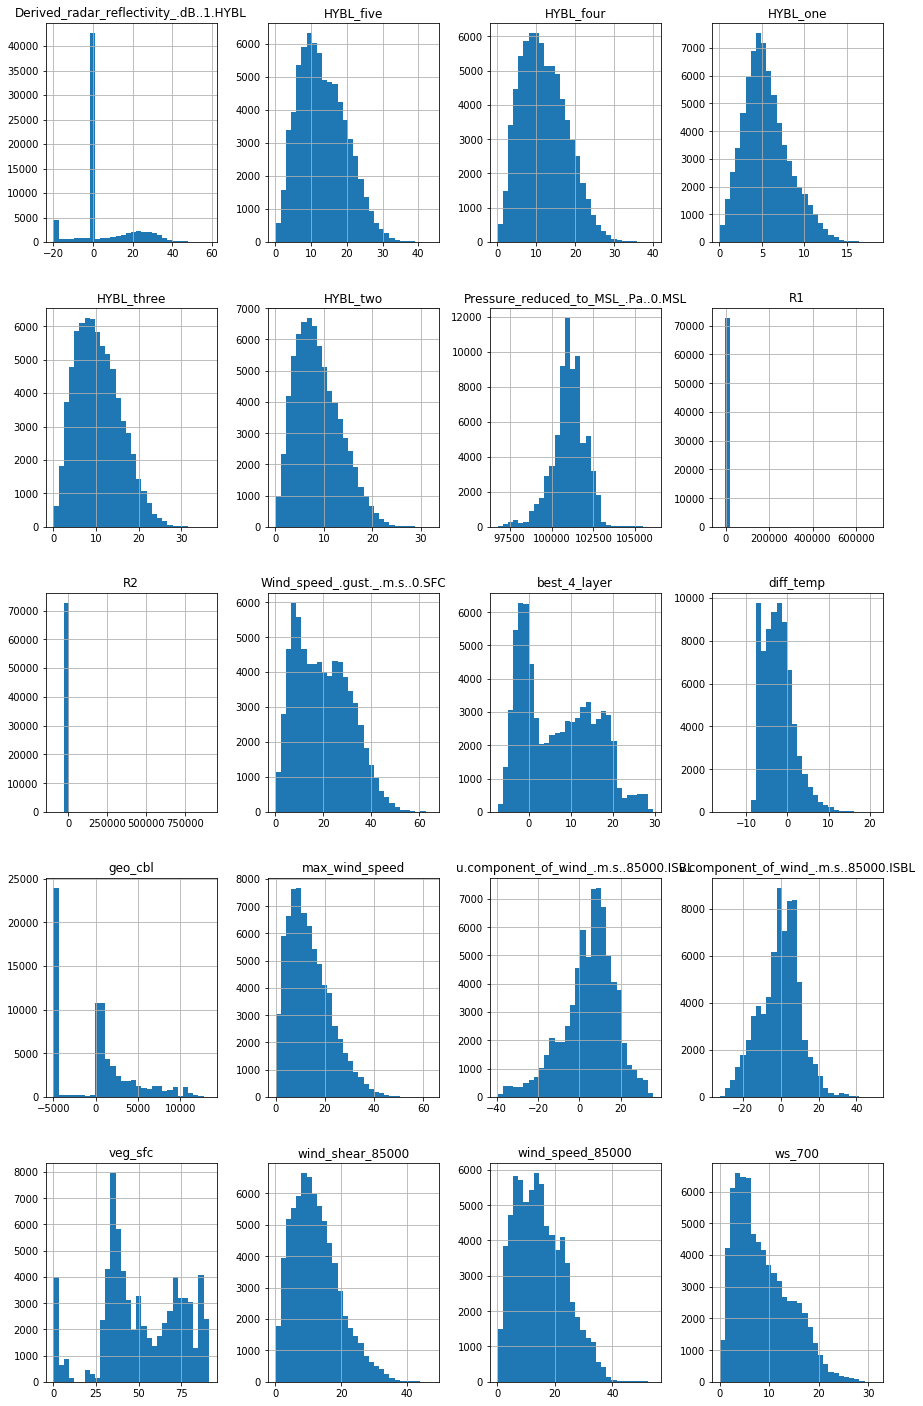

In [4]:
fig = plt.figure(figsize = (15,25))
ax = fig.gca()
df4.hist(ax = ax,bins = 30)

### Linear Model

### Functions used

In [5]:
def model_info1(x, y, test_date, data_tested):
    cm = confusion_matrix(x,y)
    acc = accuracy_score(x,y)
    cm = confusion_matrix(x,y)
    if len(cm) > 1:
        hit = cm[1][1]
        false_alarms = cm[0][1]
        misses = cm[1][0]
        no_events = cm[0][0]
        csi = hit / (false_alarms + misses + hit)
        hit_rate = hit / (hit + misses)
        false_alarm_rate = false_alarms / (hit + false_alarms)
    else:
        hit = 0
        false_alarms = 0
        misses = 0
        no_events = cm[0][0]
        csi = 0
        hit_rate =0
        false_alarm_rate = 0
    data = [{"Accuracy":acc,"Hits":hit, "False Alarms":false_alarms, 'Misses':misses,'No Events': no_events, 'CSI':csi, 'Hit Rate':hit_rate, 'False Alarm Rate':false_alarm_rate}]
    df = pd.DataFrame(data)
    df['test_date'] = test_date
    df['data_tested'] = data_tested
    if len(Counter(x)) == 1:
        l30 = Counter(x)[0]
        df['greter_than_30_knots'] = '0'
        df['less_than_30_knots'] = l30
    else:
        g30 = Counter(x)[1]
        l30 = Counter(x)[0]
        df['greter_than_30_knots'] = g30
        df['less_than_30_knots'] = l30
    return (df)

def model_info2(x, y,test_date,data_tested):
    mae = mean_absolute_error(x,y)
    mse = mean_squared_error(x,y)
    r2 = r2_score(x,y)
    residual_0 = x - y
    res_0 = np.array(residual_0)
    res_mean = round(res_0.mean(),4)
    data = [{"MAE":mae ,"MSE":mse, 'Residual Mean':res_mean}]
    df = pd.DataFrame(data)
    df['test_date'] = test_date
    df['data_tested'] = data_tested
    return (df)

In [6]:
df2 = df[['Date','Type', 'from', 'EXP',
       'max_wind_speed', 'R1', 'R2',
       'Pressure_reduced_to_MSL_.Pa..0.MSL',
       'Derived_radar_reflectivity_.dB..1.HYBL',
       'u.component_of_wind_.m.s..85000.ISBL',
       'v.component_of_wind_.m.s..85000.ISBL', 'wind_speed_85000',
       'wind_shear_85000', 'Wind_speed_.gust._.m.s..0.SFC', 'HYBL_one',
       'HYBL_two', 'HYBL_three', 'HYBL_four', 'HYBL_five', 'diff_temp',
       'geo_cbl', 'veg_sfc', 'best_4_layer', 'ws_700']]
le = LabelEncoder()
df2['from'] = le.fit_transform(df2['from'])
df2.tail()

,Date,Type,from,EXP,max_wind_speed,R1,R2,Pressure_reduced_to_MSL_.Pa..0.MSL,Derived_radar_reflectivity_.dB..1.HYBL,u.component_of_wind_.m.s..85000.ISBL,...,HYBL_one,HYBL_two,HYBL_three,HYBL_four,HYBL_five,diff_temp,geo_cbl,veg_sfc,best_4_layer,ws_700
72644,2018-07-22 05:00:00,WBOU,1,7/21/18,18.466480,0.208045,0.611219,101261.039,12.085,-23.288,...,7.816662,15.680860,17.975858,20.447715,23.181813,1.781,617.054,81.379,-0.242,13.064799
72645,2018-07-22 05:15:00,WBOU,1,7/21/18,14.190032,0.299167,0.862250,101300.672,30.468,-22.240,...,9.473530,16.257336,18.523830,20.886978,23.647179,3.054,617.312,81.379,1.156,6.802500
72646,2018-07-22 05:30:00,WBOU,1,7/21/18,18.272096,0.322338,0.820237,101246.523,36.629,-23.286,...,10.101133,16.429774,18.594468,20.983602,24.190719,3.830,613.479,81.379,0.427,5.752790
72647,2018-07-22 05:45:00,WBOU,1,7/21/18,17.105792,0.279731,0.693772,101143.383,34.181,-23.227,...,9.634310,16.364893,18.456569,21.401767,24.263238,3.607,554.661,81.379,0.706,8.964475
72648,2018-07-22 06:00:00,WBOU,1,7/21/18,17.105792,0.231301,0.605321,101104.297,36.779,-26.560,...,8.939975,16.514877,18.701148,22.068564,24.935163,3.349,555.042,81.379,0.171,7.752404


In [7]:
### model function
def rf_model(x):

    test_1 = df2[df2.EXP == x]
    train_1 = df2[df2.EXP != x]

    train_1 = train_1[['Date','Type', 'from',
           'max_wind_speed', 'R1', 'R2',
           'Pressure_reduced_to_MSL_.Pa..0.MSL',
           'Derived_radar_reflectivity_.dB..1.HYBL',
           'u.component_of_wind_.m.s..85000.ISBL',
           'v.component_of_wind_.m.s..85000.ISBL', 'wind_speed_85000',
           'wind_shear_85000', 'Wind_speed_.gust._.m.s..0.SFC', 'HYBL_one',
           'HYBL_two', 'HYBL_three', 'HYBL_four', 'HYBL_five', 'diff_temp',
           'geo_cbl', 'veg_sfc', 'best_4_layer', 'ws_700']]


    test_1 = test_1[['Date','Type', 'from',
           'max_wind_speed', 'R1', 'R2',
           'Pressure_reduced_to_MSL_.Pa..0.MSL',
           'Derived_radar_reflectivity_.dB..1.HYBL',
           'u.component_of_wind_.m.s..85000.ISBL',
           'v.component_of_wind_.m.s..85000.ISBL', 'wind_speed_85000',
           'wind_shear_85000', 'Wind_speed_.gust._.m.s..0.SFC', 'HYBL_one',
           'HYBL_two', 'HYBL_three', 'HYBL_four', 'HYBL_five', 'diff_temp',
           'geo_cbl', 'veg_sfc', 'best_4_layer', 'ws_700']]

    x_train = train_1.drop('max_wind_speed', 1)
    x_train.drop(['Date','Type'], axis=1, inplace=True)
    y_train = train_1.max_wind_speed
    x_test = test_1.drop('max_wind_speed', 1)
    x_test_copy = x_test.copy()
    x_test.drop(['Date','Type'], axis=1, inplace=True)
    y_test = test_1.max_wind_speed
    scale = MinMaxScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test)


    model = LinearRegression()
    model.fit(x_train, y_train)

    pred_train = model.predict(x_train)
    train_info = model_info2(y_train, pred_train, x , "train")

    y_train30 = np.where(y_train > 30, 1, 0 )
    pred_train30 = np.where(pred_train > 30, 1, 0 )
    train_info2 = model_info1(y_train30, pred_train30, x,'train')


    pred_test = model.predict(x_test)
    test_info = model_info2(y_test, pred_test, x , "test")

    y_test30 = np.where(y_test > 30, 1, 0 )
    pred_test30 = np.where(pred_test > 30, 1, 0 )
    test_info2 = model_info1(y_test30, pred_test30, x,'test')

    table = train_info.append(test_info)
    table2 = train_info2.append(test_info2)
    print(x)
    print(table)
    print("==" *10)
    print(table2)

    df4 = pd.DataFrame(y_test)
    df4 = df4.rename(columns={'max_wind_speed': 'actual'})
    df4 = df4.reset_index()
    df4.drop('index', axis=1, inplace=True)
    x_test_copy = x_test_copy.reset_index()
    x_test_copy.drop("index", axis=1, inplace=True)
    df5 = pd.concat([x_test_copy, df4], axis=1)
    pred_df = pd.DataFrame(pred_test, columns=["pred"])
    df6 = pd.concat([df5, pred_df], axis=1)
    df6['From'] = np.where(df6['from'] == 1, 'Mesonet', 'ASOS')
    df6.drop('from', inplace=True, axis=1)
    df6['test_date'] = x
    return(table, table2, df6)

In [8]:
table = pd.DataFrame()
table_class = pd.DataFrame()
data = pd.DataFrame()
for i in df['EXP'].unique():
    t,tc,d = rf_model(i)
    table = table.append(t)
    table_class = table_class.append(tc)
    data = data.append(d)

1/7/17
        MAE        MSE  Residual Mean test_date data_tested
0  4.165595  29.298007         0.0000    1/7/17       train
0  2.995109  14.135034        -1.7529    1/7/17        test
   Accuracy  Hits  False Alarms  Misses  No Events       CSI  Hit Rate  \
0  0.951408   481           286    3149      66774  0.122829  0.132507   
0  1.000000     0             0       0       1959  0.000000  0.000000   

   False Alarm Rate test_date data_tested greter_than_30_knots  \
0          0.372881    1/7/17       train                 3630   
0          0.000000    1/7/17        test                    0   

   less_than_30_knots  
0               67060  
0                1959  
2/9/17
        MAE        MSE  Residual Mean test_date data_tested
0  4.143541  29.138360         0.0000    2/9/17       train
0  3.610134  19.887062        -1.0659    2/9/17        test
   Accuracy  Hits  False Alarms  Misses  No Events       CSI  Hit Rate  \
0  0.951961   475           289    3102      66722  0.1228

1/4/18
        MAE        MSE  Residual Mean test_date data_tested
0  4.095894  28.516717        -0.0000    1/4/18       train
0  4.876329  41.570567         2.5159    1/4/18        test
   Accuracy  Hits  False Alarms  Misses  No Events       CSI  Hit Rate  \
0  0.954355   417           233    2970      66552  0.115193  0.123118   
0  0.903109     3             0     240       2234  0.012346  0.012346   

   False Alarm Rate test_date data_tested  greter_than_30_knots  \
0          0.358462    1/4/18       train                  3387   
0          0.000000    1/4/18        test                   243   

   less_than_30_knots  
0               66785  
0                2234  
3/2/18
        MAE        MSE  Residual Mean test_date data_tested
0  4.102185  28.586787          0.000    3/2/18       train
0  4.908436  38.283708         -1.918    3/2/18        test
   Accuracy  Hits  False Alarms  Misses  No Events       CSI  Hit Rate  \
0  0.953303   441           267    3012      66499  0.1

9/10/18
        MAE        MSE  Residual Mean test_date data_tested
0  4.122362  28.938315        -0.0000   9/10/18       train
0  4.290552  29.429525         3.0015   9/10/18        test
   Accuracy  Hits  False Alarms  Misses  No Events       CSI  Hit Rate  \
0  0.951241   486           293    3139      66469  0.124043  0.134069   
0  0.997790     0             0       5       2257  0.000000  0.000000   

   False Alarm Rate test_date data_tested  greter_than_30_knots  \
0          0.376123   9/10/18       train                  3625   
0               NaN   9/10/18        test                     5   

   less_than_30_knots  
0               66762  
0                2257  
9/26/18
        MAE        MSE  Residual Mean test_date data_tested
0  4.141155  29.112491         0.0000   9/26/18       train
0  3.578527  20.916652         0.3811   9/26/18        test
   Accuracy  Hits  False Alarms  Misses  No Events       CSI  Hit Rate  \
0  0.951123   484           300    3146      66574  0

In [9]:
#table.to_csv('32_stats.csv')
table.head()

,MAE,MSE,Residual Mean,test_date,data_tested
0,4.165595,29.298007,0.0000,1/7/17,train
0,2.995109,14.135034,-1.7529,1/7/17,test
0,4.143541,29.138360,0.0000,2/9/17,train
0,3.610134,19.887062,-1.0659,2/9/17,test
0,4.074301,28.231467,0.0000,2/13/17,train


In [10]:
#data.to_csv('32_data.csv')
data.head()

,Date,Type,R1,R2,Pressure_reduced_to_MSL_.Pa..0.MSL,Derived_radar_reflectivity_.dB..1.HYBL,u.component_of_wind_.m.s..85000.ISBL,v.component_of_wind_.m.s..85000.ISBL,wind_speed_85000,wind_shear_85000,...,HYBL_five,diff_temp,geo_cbl,veg_sfc,best_4_layer,ws_700,actual,pred,From,test_date
0,2017-01-07 06:00:00,ANDE,2.630564,2.322274,102879.7,0.0,5.447,-1.457,5.638498,5.269992,...,6.054984,0.739,-5000.0,40.293,23.757,16.787335,2.332608,5.749232,Mesonet,1/7/17
1,2017-01-07 06:15:00,ANDE,2.055383,1.813005,102951.0,0.0,5.629,-1.464,5.816265,5.773324,...,6.394255,1.050,-5000.0,40.293,23.959,16.195689,1.555072,6.420744,Mesonet,1/7/17
2,2017-01-07 06:30:00,ANDE,1.792587,1.671478,102890.6,0.0,5.653,-1.560,5.864300,6.232140,...,6.395084,1.211,-5000.0,40.293,24.118,15.636587,2.332608,6.823966,Mesonet,1/7/17
3,2017-01-07 06:45:00,ANDE,1.442889,1.352497,102931.0,0.0,5.692,-2.445,6.194908,6.806583,...,6.869857,0.943,-5000.0,40.293,24.220,16.767452,1.555072,7.983241,Mesonet,1/7/17
4,2017-01-07 07:00:00,ANDE,2.283417,1.677404,102882.5,0.0,5.226,-3.060,6.055962,5.554556,...,6.783159,0.751,-5000.0,40.293,24.149,17.249375,2.526992,8.253846,Mesonet,1/7/17


In [11]:
#table_class.to_csv('32_stats_class.csv')
table_class.head()

,Accuracy,Hits,False Alarms,Misses,No Events,CSI,Hit Rate,False Alarm Rate,test_date,data_tested,greter_than_30_knots,less_than_30_knots
0,0.951408,481,286,3149,66774,0.122829,0.132507,0.372881,1/7/17,train,3630,67060
0,1.000000,0,0,0,1959,0.000000,0.000000,0.000000,1/7/17,test,0,1959
0,0.951961,475,289,3102,66722,0.122866,0.132793,0.378272,2/9/17,train,3577,67011
0,0.974284,0,0,53,2008,0.000000,0.000000,NaN,2/9/17,test,53,2008
0,0.957407,279,201,2810,67402,0.084802,0.090320,0.418750,2/13/17,train,3089,67603


In [13]:
table.groupby('data_tested').agg({'MAE':'mean', 'Residual Mean':'mean'})

,MAE,Residual Mean
data_tested,,
test,4.268192,-0.025903
train,4.122862,0.000000


In [14]:
res = data['actual'] - data['pred']
res.mean()

-0.05236295569495071

### Sample 10

- Took a random sample of x amount of days to train model

In [17]:
def rf_model2(x,sample):

    test_1 = df2[df2.EXP == x]
    train_1 = df2[df2.EXP != x]
    exp = train_1['EXP'].unique()
    smp = np.random.choice(exp,sample, replace = False)
    train2 = train_1[train_1['EXP'].isin(smp)]
    print(len(train2['EXP'].unique()))

    train2 = train2[['Type', 'from',
       'max_wind_speed', 'R1', 'R2',
       'Pressure_reduced_to_MSL_.Pa..0.MSL',
       'Derived_radar_reflectivity_.dB..1.HYBL',
       'u.component_of_wind_.m.s..85000.ISBL',
       'v.component_of_wind_.m.s..85000.ISBL', 'wind_speed_85000',
       'wind_shear_85000', 'Wind_speed_.gust._.m.s..0.SFC', 'HYBL_one',
       'HYBL_two', 'HYBL_three', 'HYBL_four', 'HYBL_five', 'diff_temp',
       'geo_cbl', 'veg_sfc', 'best_4_layer', 'ws_700']]


    test_1 = test_1[['Type', 'from',
       'max_wind_speed', 'R1', 'R2',
       'Pressure_reduced_to_MSL_.Pa..0.MSL',
       'Derived_radar_reflectivity_.dB..1.HYBL',
       'u.component_of_wind_.m.s..85000.ISBL',
       'v.component_of_wind_.m.s..85000.ISBL', 'wind_speed_85000',
       'wind_shear_85000', 'Wind_speed_.gust._.m.s..0.SFC', 'HYBL_one',
       'HYBL_two', 'HYBL_three', 'HYBL_four', 'HYBL_five', 'diff_temp',
       'geo_cbl', 'veg_sfc', 'best_4_layer', 'ws_700']]

    x_train = train2.drop('max_wind_speed', 1)
    x_train.drop('Type', axis=1, inplace=True)
    y_train = train2.max_wind_speed
    x_test = test_1.drop('max_wind_speed', 1)
    x_test_copy = x_test.copy()
    x_test.drop('Type', axis=1, inplace=True)
    y_test = test_1.max_wind_speed
    scale = MinMaxScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test)
    
    ll = list(smp)
    dates = " ".join(str(x) for x in ll)

    model = LinearRegression()
    model.fit(x_train, y_train)

    pred_train = model.predict(x_train)
    train_info = model_info2(y_train, pred_train, x , "train",)

    pred_test = model.predict(x_test)
    test_info = model_info2(y_test, pred_test, x , "test",)

    table = train_info.append(test_info)
    table['train_dates'] = dates
    table['number_sample'] = sample
    print(x)
    print(table)
    print("--" * 40)

    df4 = pd.DataFrame(y_test)
    df4 = df4.rename(columns={'max_wind_speed': 'actual'})
    df4 = df4.reset_index()
    df4.drop('index', axis=1, inplace=True)
    x_test_copy = x_test_copy.reset_index()
    x_test_copy.drop("index", axis=1, inplace=True)
    df5 = pd.concat([x_test_copy, df4], axis=1)
    pred_df = pd.DataFrame(pred_test, columns=["pred"])
    df6 = pd.concat([df5, pred_df], axis=1)
    df6['From'] = np.where(df6['from'] == 1, 'Mesonet', 'ASOS')
    df6.drop('from', inplace=True, axis=1)
    df6['test_date'] = x
    df6['number_sample'] = sample
    return (table, df6)

In [18]:
table = pd.DataFrame()
data = pd.DataFrame()
for i in df['EXP'].unique():
    t,d = rf_model2(i,10)
    table = table.append(t)
    data = data.append(d)

10
1/7/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  3.969407  26.997766        -0.0000    1/7/17       train   
0  2.751054  11.873748        -0.5748    1/7/17        test   

                                         train_dates  number_sample  
0  9/4/18 6/13/18 8/17/18 10/2/18 2/13/17 5/15/18...             10  
0  9/4/18 6/13/18 8/17/18 10/2/18 2/13/17 5/15/18...             10  
--------------------------------------------------------------------------------
10
2/9/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.228370  31.095954         0.0000    2/9/17       train   
0  3.424595  18.545822        -0.3876    2/9/17        test   

                                         train_dates  number_sample  
0  8/17/18 7/13/17 2/24/19 3/2/18 10/12/18 12/9/1...             10  
0  8/17/18 7/13/17 2/24/19 3/2/18 10/12/18 12/9/1...             10  
--------------------------------------------------------------------------------
10
2/13/17
       

5/26/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  3.813573  24.410170         0.0000   5/26/18       train   
0  2.840681  12.697523        -0.6059   5/26/18        test   

                                         train_dates  number_sample  
0  12/22/18 3/2/17 2/25/17 10/27/18 7/13/17 3/21/...             10  
0  12/22/18 3/2/17 2/25/17 10/27/18 7/13/17 3/21/...             10  
--------------------------------------------------------------------------------
10
6/13/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  3.873521  25.336359         0.0000   6/13/18       train   
0  2.965559  14.799907         0.3615   6/13/18        test   

                                         train_dates  number_sample  
0  9/4/18 5/26/18 7/21/18 8/17/18 3/14/17 7/13/17...             10  
0  9/4/18 5/26/18 7/21/18 8/17/18 3/14/17 7/13/17...             10  
--------------------------------------------------------------------------------
10
7/17/18
        

In [19]:
#table.to_csv('10_sample_lin_stats.csv')
table.head()

,MAE,MSE,Residual Mean,test_date,data_tested,train_dates,number_sample
0,3.969407,26.997766,-0.0000,1/7/17,train,9/4/18 6/13/18 8/17/18 10/2/18 2/13/17 5/15/18...,10
0,2.751054,11.873748,-0.5748,1/7/17,test,9/4/18 6/13/18 8/17/18 10/2/18 2/13/17 5/15/18...,10
0,4.228370,31.095954,0.0000,2/9/17,train,8/17/18 7/13/17 2/24/19 3/2/18 10/12/18 12/9/1...,10
0,3.424595,18.545822,-0.3876,2/9/17,test,8/17/18 7/13/17 2/24/19 3/2/18 10/12/18 12/9/1...,10
0,3.661885,23.095660,0.0000,2/13/17,train,1/7/17 9/4/18 11/19/17 2/9/17 7/21/18 10/12/18...,10


In [20]:
#data.to_csv('10_sample_lin_data.csv')
data.head()

,Type,R1,R2,Pressure_reduced_to_MSL_.Pa..0.MSL,Derived_radar_reflectivity_.dB..1.HYBL,u.component_of_wind_.m.s..85000.ISBL,v.component_of_wind_.m.s..85000.ISBL,wind_speed_85000,wind_shear_85000,Wind_speed_.gust._.m.s..0.SFC,...,diff_temp,geo_cbl,veg_sfc,best_4_layer,ws_700,actual,pred,From,test_date,number_sample
0,ANDE,2.630564,2.322274,102879.7,0.0,5.447,-1.457,5.638498,5.269992,1.166,...,0.739,-5000.0,40.293,23.757,16.787335,2.332608,5.041550,Mesonet,1/7/17,10
1,ANDE,2.055383,1.813005,102951.0,0.0,5.629,-1.464,5.816265,5.773324,1.556,...,1.050,-5000.0,40.293,23.959,16.195689,1.555072,5.630199,Mesonet,1/7/17,10
2,ANDE,1.792587,1.671478,102890.6,0.0,5.653,-1.560,5.864300,6.232140,2.611,...,1.211,-5000.0,40.293,24.118,15.636587,2.332608,6.143383,Mesonet,1/7/17,10
3,ANDE,1.442889,1.352497,102931.0,0.0,5.692,-2.445,6.194908,6.806583,4.295,...,0.943,-5000.0,40.293,24.220,16.767452,1.555072,7.071621,Mesonet,1/7/17,10
4,ANDE,2.283417,1.677404,102882.5,0.0,5.226,-3.060,6.055962,5.554556,4.836,...,0.751,-5000.0,40.293,24.149,17.249375,2.526992,7.266990,Mesonet,1/7/17,10


In [21]:
table.groupby('data_tested').agg({'MAE':'mean', 'Residual Mean':'mean'})

,MAE,Residual Mean
data_tested,,
test,4.569116,0.217275
train,3.986329,0.000000


In [22]:
res = data['actual'] - data['pred']
res.mean()

0.16081851647943493

### 15 Samples

In [23]:
table = pd.DataFrame()
data = pd.DataFrame()
for i in df['EXP'].unique():
    t,d = rf_model2(i,15)
    table = table.append(t)
    data = data.append(d)

15
1/7/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  3.904634  25.997136        -0.0000    1/7/17       train   
0  3.303447  16.690786        -2.3066    1/7/17        test   

                                         train_dates  number_sample  
0  7/17/18 2/24/19 10/29/17 10/12/18 12/9/17 5/26...             15  
0  7/17/18 2/24/19 10/29/17 10/12/18 12/9/17 5/26...             15  
--------------------------------------------------------------------------------
15
2/9/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.219858  29.931858         0.0000    2/9/17       train   
0  3.880947  23.561609        -1.2958    2/9/17        test   

                                         train_dates  number_sample  
0  8/17/18 11/19/17 3/2/18 12/17/18 2/13/17 5/15/...             15  
0  8/17/18 11/19/17 3/2/18 12/17/18 2/13/17 5/15/...             15  
--------------------------------------------------------------------------------
15
2/13/17
       

15
5/26/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.260425  30.185636        -0.0000   5/26/18       train   
0  3.278112  16.450996        -0.4303   5/26/18        test   

                                         train_dates  number_sample  
0  12/17/18 9/26/18 5/15/18 10/2/18 9/10/18 12/22...             15  
0  12/17/18 9/26/18 5/15/18 10/2/18 9/10/18 12/22...             15  
--------------------------------------------------------------------------------
15
6/13/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.105232  28.279830        -0.0000   6/13/18       train   
0  3.820121  23.308137        -2.0642   6/13/18        test   

                                         train_dates  number_sample  
0  10/12/18 9/10/18 10/2/18 9/4/18 3/2/18 1/7/17 ...             15  
0  10/12/18 9/10/18 10/2/18 9/4/18 3/2/18 1/7/17 ...             15  
--------------------------------------------------------------------------------
15
7/17/18
     

In [79]:
#table.to_csv('15_sample_lin_stats.csv')
#data.to_csv('15_sample_lin_data.csv')

In [25]:
table.groupby('data_tested').agg({'MAE':'mean', 'Residual Mean':'mean'})

,MAE,Residual Mean
data_tested,,
test,4.369527,0.130628
train,4.068995,0.000000


In [26]:
res = data['actual'] - data['pred']
res.mean()

0.10385816082974941

### 20 Samples

In [27]:
table = pd.DataFrame()
data = pd.DataFrame()
for i in df['EXP'].unique():
    t,d = rf_model2(i,20)
    table = table.append(t)
    data = data.append(d)

20
1/7/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  3.841065  25.352770         0.0000    1/7/17       train   
0  2.686807  11.252659        -0.4454    1/7/17        test   

                                         train_dates  number_sample  
0  9/4/18 3/7/18 3/22/17 3/14/17 12/9/17 7/13/17 ...             20  
0  9/4/18 3/7/18 3/22/17 3/14/17 12/9/17 7/13/17 ...             20  
--------------------------------------------------------------------------------
20
2/9/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.130743  28.742432         -0.000    2/9/17       train   
0  3.765924  21.174469         -1.688    2/9/17        test   

                                         train_dates  number_sample  
0  9/4/18 9/10/18 3/7/18 3/21/18 2/24/19 3/14/17 ...             20  
0  9/4/18 9/10/18 3/7/18 3/21/18 2/24/19 3/14/17 ...             20  
--------------------------------------------------------------------------------
20
2/13/17
       

6/13/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.170386  29.294113        -0.0000   6/13/18       train   
0  3.549066  20.246510        -1.6898   6/13/18        test   

                                         train_dates  number_sample  
0  5/26/18 2/25/17 10/29/17 5/15/18 8/17/18 9/26/...             20  
0  5/26/18 2/25/17 10/29/17 5/15/18 8/17/18 9/26/...             20  
--------------------------------------------------------------------------------
20
7/17/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.167935  29.331654        -0.0000   7/17/18       train   
0  4.146282  28.694288         1.0035   7/17/18        test   

                                         train_dates  number_sample  
0  11/19/17 5/15/18 9/10/18 2/25/17 3/2/17 1/7/17...             20  
0  11/19/17 5/15/18 9/10/18 2/25/17 3/2/17 1/7/17...             20  
--------------------------------------------------------------------------------
20
7/21/18
        

In [84]:
table.to_csv('20_sample_lin_stats.csv')
data.to_csv('20_sample_lin_data.csv')

In [85]:
table.groupby('data_tested').agg({'MAE':'mean', 'R2':'mean', 'Residual Mean':'mean'})

,MAE,R2,Residual Mean
data_tested,,,
test,4.476691,0.182132,0.293803
train,4.057712,0.601161,0.000000


In [86]:
res = data['actual'] - data['pred']
res.mean()

0.25706469994977715

### 25 Samples

In [87]:
table = pd.DataFrame()
data = pd.DataFrame()
for i in df['EXP'].unique():
    t,d = rf_model2(i,25)
    table = table.append(t)
    data = data.append(d)

1/7/17
        MAE        MSE        R2  Residual Mean test_date data_tested  \
0  3.952940  26.681087  0.630766         0.0000    1/7/17       train   
0  2.751734  11.786560  0.600759        -0.7216    1/7/17        test   

                                         train_dates  number_sample  
0  3/7/18 8/17/18 2/25/17 6/13/18 7/13/17 5/15/18...             25  
0  3/7/18 8/17/18 2/25/17 6/13/18 7/13/17 5/15/18...             25  
--------------------------------------------------------------------------------
2/9/17
        MAE        MSE        R2  Residual Mean test_date data_tested  \
0  3.943145  26.554029  0.654196         0.0000    2/9/17       train   
0  3.572262  20.127458  0.573342        -0.2483    2/9/17        test   

                                         train_dates  number_sample  
0  5/26/18 3/7/18 11/19/17 11/19/17 9/10/18 12/22...             25  
0  5/26/18 3/7/18 11/19/17 11/19/17 9/10/18 12/22...             25  
---------------------------------------------

6/13/18
        MAE        MSE        R2  Residual Mean test_date data_tested  \
0  3.727310  24.222942  0.638031         0.0000   6/13/18       train   
0  3.600851  20.842852 -0.392039        -1.6257   6/13/18        test   

                                         train_dates  number_sample  
0  2/24/19 9/6/18 10/2/18 10/27/18 10/12/18 8/17/...             25  
0  2/24/19 9/6/18 10/2/18 10/27/18 10/12/18 8/17/...             25  
--------------------------------------------------------------------------------
7/17/18
        MAE        MSE        R2  Residual Mean test_date data_tested  \
0  3.971868  26.811912  0.574276         0.0000   7/17/18       train   
0  4.241066  30.213787  0.007944         1.5008   7/17/18        test   

                                         train_dates  number_sample  
0  6/13/18 2/24/19 2/24/19 12/9/17 7/13/17 6/19/1...             25  
0  6/13/18 2/24/19 2/24/19 12/9/17 7/13/17 6/19/1...             25  
-------------------------------------------

In [28]:
#table.to_csv('25_sample_lin_stats.csv')
#data.to_csv('25_sample_lin_data.csv')

In [29]:
table.groupby('data_tested').agg({'MAE':'mean', 'Residual Mean':'mean'})

,MAE,Residual Mean
data_tested,,
test,4.276017,-0.015228
train,4.057346,0.000000


In [30]:
res = data['actual'] - data['pred']
res.mean()

-0.05038507298526941

### 30 Samples

In [31]:
table = pd.DataFrame()
data = pd.DataFrame()
for i in df['EXP'].unique():
    t,d = rf_model2(i,30)
    table = table.append(t)
    data = data.append(d)

30
1/7/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.187044  29.546705         0.0000    1/7/17       train   
0  2.993159  14.158708        -1.7474    1/7/17        test   

                                         train_dates  number_sample  
0  10/12/18 9/4/18 2/24/19 3/2/18 12/22/18 6/19/1...             30  
0  10/12/18 9/4/18 2/24/19 3/2/18 12/22/18 6/19/1...             30  
--------------------------------------------------------------------------------
30
2/9/17
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.177589  29.632371        -0.0000    2/9/17       train   
0  3.612833  19.895087        -1.1237    2/9/17        test   

                                         train_dates  number_sample  
0  5/26/18 12/9/17 3/2/17 9/26/18 1/4/18 3/2/18 1...             30  
0  5/26/18 12/9/17 3/2/17 9/26/18 1/4/18 3/2/18 1...             30  
--------------------------------------------------------------------------------
30
2/13/17
       

30
6/13/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.115288  28.802725        -0.0000   6/13/18       train   
0  3.670167  21.582492        -1.7509   6/13/18        test   

                                         train_dates  number_sample  
0  9/6/18 12/17/18 7/13/17 7/17/18 10/2/18 2/13/1...             30  
0  9/6/18 12/17/18 7/13/17 7/17/18 10/2/18 2/13/1...             30  
--------------------------------------------------------------------------------
30
7/17/18
        MAE        MSE  Residual Mean test_date data_tested  \
0  4.143535  29.120677        -0.0000   7/17/18       train   
0  4.118887  28.626568         1.2125   7/17/18        test   

                                         train_dates  number_sample  
0  3/21/18 8/17/18 12/17/18 9/10/18 10/29/17 1/4/...             30  
0  3/21/18 8/17/18 12/17/18 9/10/18 10/29/17 1/4/...             30  
--------------------------------------------------------------------------------
30
7/21/18
     

In [32]:
#table.to_csv('30_sample_lin_stats.csv')
#data.to_csv('30_sample_lin_data.csv')

In [33]:
table.groupby('data_tested').agg({'MAE':'mean', 'Residual Mean':'mean'})

,MAE,Residual Mean
data_tested,,
test,4.271773,-0.060262
train,4.114240,0.000000


In [34]:
res = data['actual'] - data['pred']
res.mean()

-0.08998026349542831